# OxAria NO2 sensor baseline analysis


This analysis explores the application of statistical algorithms development in the analytical spectroscopy domain for handling & correction of baseline offsets within OxAria sensor data holdings & utilising reference method observations at (Oxford) city background & city roadside locations as a frame of reference.

Time series plots of 15-minute average NO2 concentrations (Fig1.) have shown that sensor baseline conditions exhibited by sensors across the OxAria sensor newtork were broadly stable during 2020, with some excepts. However, it is also noted from Fig1 that the offset in the sensor baseline signal varies from sensor to sensor. 
Variability in the sensor baseline offset presents a barrier to developing & applying a common regression model to correct for sensor interferences across the OxAria sensor data holdings. This in turnis an obstacle for data handling efficacy & transparency.

## Aim
* A simple, robust, replicable & recognised method for correction of sensor baseline offset
* Easily deployable across the OxAria network
* Facilating the deployment of regression models for correction of NO2 sensor interferences


In [1]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator
import matplotlib as mpl
import peakutils
from peakutils.plot import plot as pplot
import warnings
warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
#----------------
the_gases = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/pngs/gap_filling/'
the_folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'


In [2]:
# Load stable 15-min sensor data as single df
#---------------------------------------------
gases = pd.read_feather(the_folder + 'oxaria_gases_536_stable15.ftr')

# Load AURN 15-min data as single df
#------------------------------------
auto_merged = pd.read_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/auto_merged_ratified.ftr')

# Quite possible the baselines will have already been calculated, 
# so dropping these for recalc
#auto_merged.drop(columns=['no2_ppb_h_bl', 'no2_ppb_s_bl'],
#                 axis=1,
#                 inplace=True)
# Quite possible the baselines will have already been calculated,
# so dropping these for recalc
try:
    auto_merged.drop(
        columns=['no2_ppb_h_bl', 'no2_ppb_s_bl'],
        axis=1,
        inplace=True)
except Exception:
    pass

In [3]:
gases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339525 entries, 0 to 339524
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   tag            339525 non-null  object             
 1   rec            339525 non-null  datetime64[ns, UTC]
 2   val.no2.wev    339525 non-null  float32            
 3   val.no2.cnc    339525 non-null  float32            
 4   val.no2.aev    339525 non-null  float32            
 5   val.no2.wec    339525 non-null  float32            
 6   val.sht.hmd    339525 non-null  float32            
 7   val.sht.tmp    339525 non-null  float32            
 8   val.no2.cnc_1  335248 non-null  float32            
 9   name           339525 non-null  object             
dtypes: datetime64[ns, UTC](1), float32(7), object(2)
memory usage: 16.8+ MB


In [4]:
# Calc mean, std dev & coeff of variation for each sensor
#---------------------------------------------------------
for tag, dat in gases.groupby('tag'):
    x = dat['val.no2.cnc_1'].std()
    y = dat['val.no2.cnc_1'].mean()
    p = x / y
    print(f'Mean, std. deviation & CV of {tag} is: {y:.0f},    {x:.1f},     {p:.1f}.')

Mean, std. deviation & CV of scs-bgx-536 is: -1282,    457.0,     -0.4.
Mean, std. deviation & CV of scs-bgx-537 is: 76,    8.9,     0.1.
Mean, std. deviation & CV of scs-bgx-538 is: 115,    10.3,     0.1.
Mean, std. deviation & CV of scs-bgx-539 is: 25,    11.4,     0.5.
Mean, std. deviation & CV of scs-bgx-540 is: 24,    6.9,     0.3.
Mean, std. deviation & CV of scs-bgx-541 is: 66,    9.0,     0.1.
Mean, std. deviation & CV of scs-bgx-542 is: 68,    28.8,     0.4.
Mean, std. deviation & CV of scs-bgx-543 is: 49,    22.1,     0.4.
Mean, std. deviation & CV of scs-bgx-550 is: 30,    28.8,     1.0.
Mean, std. deviation & CV of scs-bgx-551 is: 29,    12.4,     0.4.
Mean, std. deviation & CV of scs-bgx-552 is: 46,    8.8,     0.2.
Mean, std. deviation & CV of scs-bgx-553 is: 25,    14.6,     0.6.
Mean, std. deviation & CV of scs-bgx-554 is: 29,    12.7,     0.4.
Mean, std. deviation & CV of scs-bgx-556 is: 26,    21.3,     0.8.
Mean, std. deviation & CV of scs-bgx-557 is: 24,    10.5,   

In [5]:
# load airpls functions for St Ebbes baselining
# adaptive iteratively reweighted Penalized Least Squares algorithm function (airPLS)
# https://github.com/zmzhang/airPLS
#-------------------------------------------------------------------------------------

import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as plt


def als(y, lam=1e6, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z


def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z


def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)


def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z


In [6]:
# Calc St Ebbes & High St baselines using airPLS as 1st approximations
#-----------------------------------------------------------------------

# drop rows with missing values
tmp0 = auto_merged.dropna(subset=['rec', 'no2_ppb_s', 'no2_ppb_h'], axis=0)
# assign df cols to arrays
x0 = tmp0['rec'].values
ys = tmp0['no2_ppb_s'].values
yh = tmp0['no2_ppb_h'].values
# calc baseline using airpls function & default settings- st ebbes
ys_bl = airpls(
    ys, lam=400, porder=1, itermax=100
)  
# calc baseline using airpls function & default settings- high st 
yh_bl = airpls(
    yh, lam=400, porder=1, itermax=100
)
# convert arrays to dfs
x0_df = pd.DataFrame(list(x0), columns=['rec'])
y_bl_df = pd.DataFrame(list(zip(ys_bl, yh_bl)),
                       columns=['no2_ppb_s_bl', 'no2_ppb_h_bl'])
# join cols together - rec, st ebbes baseline & high st baseline
tmp1 = pd.concat([x0_df, y_bl_df], axis=1)
# housekeeping
tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                             utc=True)  #.set_index('rec',drop=True)
tmp1.set_index('rec', inplace=True, drop=True)
# join baseline info back on to source file
auto_merged = pd.merge(auto_merged, \
                       tmp1, \
                       how='left',\
                       on='rec')
# housekeeping
auto_merged.set_index('rec', inplace=True, drop=True)
auto_merged[['no2_ppb_s_bl',
             'no2_ppb_h_bl']] = auto_merged[['no2_ppb_s_bl', 'no2_ppb_h_bl'
                                             ]].astype(np.float32)


In [7]:
# Calc no2 sensor baseline with airPLS
#--------------------------------------
# create temporary list
tmp_list = []
# calc baselines for each sensor group
for tag, df in gases.groupby('tag'):
    #if tag not in 'scs-bgx-536':
    # drop rows with missing data
    tmp0 = df.dropna(subset=['rec', 'val.no2.cnc_1'], axis=0)
    # assign df cols to arrays
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.no2.cnc_1'].values
    # calc baseline using airpls function & default settings 
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  
    # convert arrays to dfs
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.no2.cnc_1_bl'])
    # join cols together - tag, rec & no2 baseline
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    # housekeeping
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)
    # append to rmp_list for each iteration
    tmp_list.append(tmp1)
# combine the list of dfs into single df    
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True)
# merge info back on to source df
gases = pd.merge(gases, tmp_df, how='left', on=['tag','rec'])
# housekeeping
gases.set_index(['tag','rec'], inplace=True, drop=True)


<Figure size 432x288 with 0 Axes>

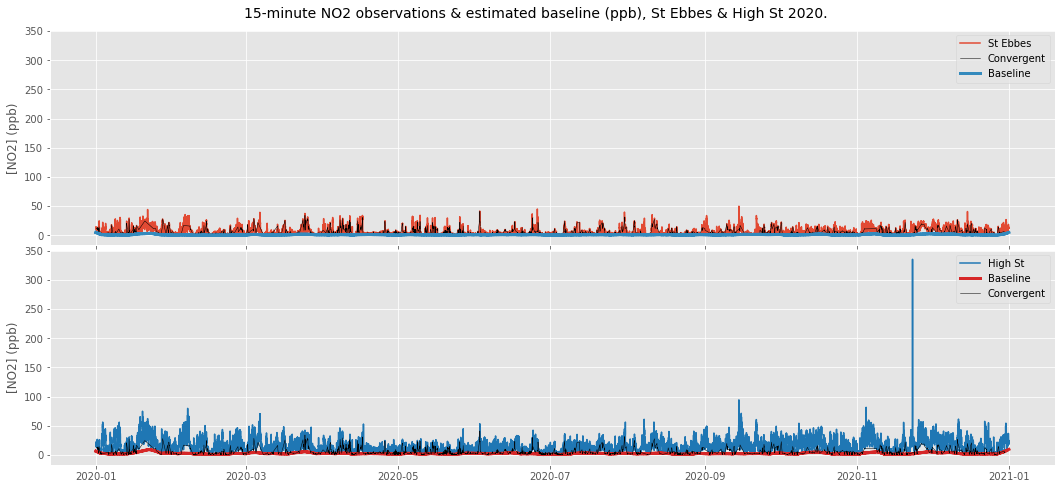

Average St Ebbes baseline = 1.00113
Average High St baseline = 2.4570124
Median St Ebbes baseline = 0.88867676
Median High St baseline = 2.20097


In [8]:
# Plot St Ebbes timeseries baseline
#-----------------------------------
plt.tight_layout()
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8),sharex=True,sharey=True)
plt.suptitle('15-minute NO2 observations & estimated baseline (ppb), St Ebbes & High St 2020.',y=0.92,fontsize=14)
ax1.plot(auto_merged.index, auto_merged['no2_ppb_s'],label='St Ebbes')
tmp = auto_merged.query('abs_no2_diff <= 2.0')
ax1.plot(tmp.index, tmp['no2_ppb_s'], lw=0.5, c='k', label='Convergent')
ax1.plot(auto_merged.index, auto_merged['no2_ppb_s_bl'], lw=3, label='Baseline')
ax2.plot(auto_merged.index, auto_merged['no2_ppb_h'],c='tab:blue',label='High St')
ax2.plot(auto_merged.index, auto_merged['no2_ppb_h_bl'], c='tab:red', lw=3,label='Baseline')
ax2.plot(tmp.index, tmp['no2_ppb_s'], lw=0.5, c='k', label='Convergent')
ax1.legend()
ax2.legend()
ax1.set_ylabel('[NO2] (ppb)')
ax2.set_ylabel('[NO2] (ppb)')

plt.subplots_adjust(hspace=0.02)
plt.show()

print('Average St Ebbes baseline = '+str(auto_merged['no2_ppb_s_bl'].mean()))
print('Average High St baseline = '+str(auto_merged['no2_ppb_h_bl'].mean()))
print('Median St Ebbes baseline = '+str(auto_merged['no2_ppb_s_bl'].median()))
print('Median High St baseline = '+str(auto_merged['no2_ppb_h_bl'].median()))

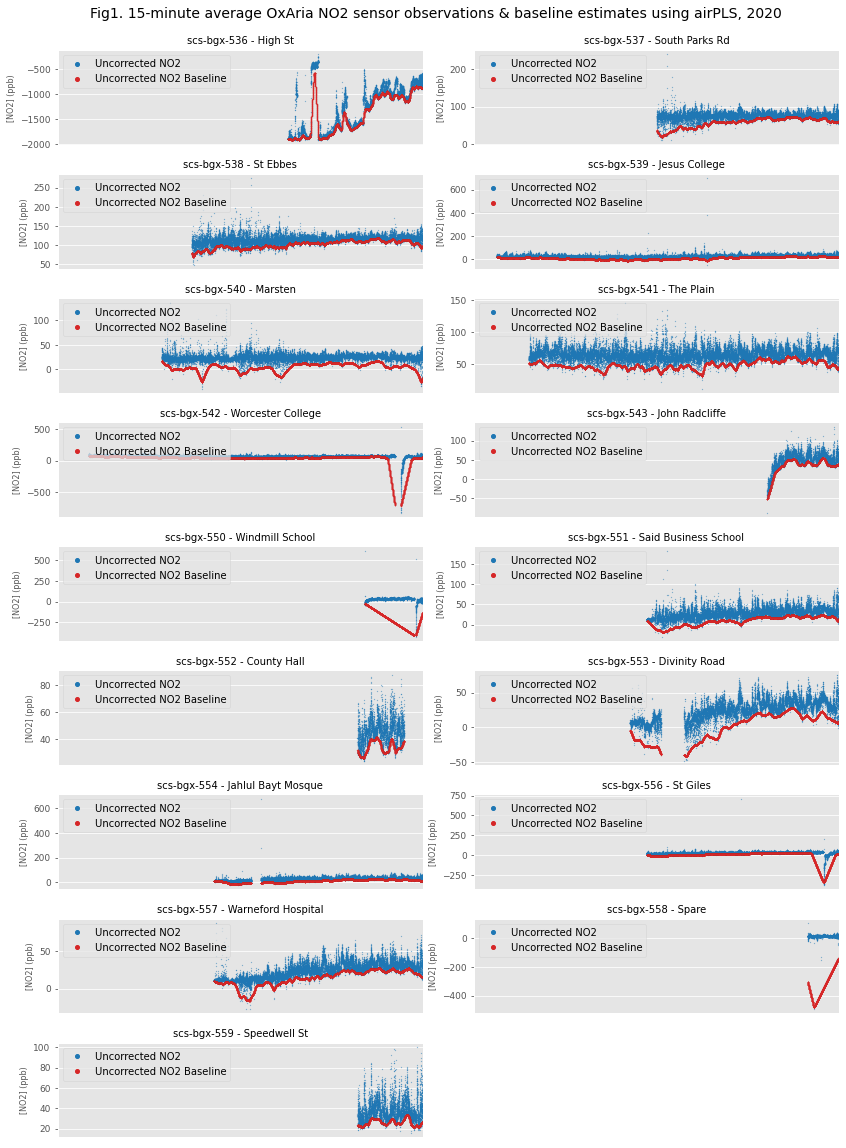

In [9]:
# Plot 15-minute snsor no2 & its baseline
#-----------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,3,1)
#labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#positions = [0,1,2,3,4,5,6,7,8,9,10,11,12]
#locations = list(pd.date_range(start_date,end_date,freq='M',normalize=True))

fig, axes = plt.subplots(nrows=9, ncols=2, sharex=True, sharey=False, figsize=(14,20))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle(
    'Fig1. 15-minute average OxAria NO2 sensor observations & baseline estimates using airPLS, 2020',
    fontsize=14,
    y=0.91)

for tag, dat in gases.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.no2.cnc_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected NO2', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected NO2 Baseline', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
        )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    #ax.set_ylim(-2000, 80)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    #ax.set_xticklabels()
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(myFmt)
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.75, loc='upper left')
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts.png')
plt.show()    
    
for ax in axes_list:
    ax.remove()


In [10]:
# Adjust sensor no2 output for baseline
#---------------------------------------
gases['val.no2.cnc_1_c0'] = gases['val.no2.cnc_1'] - gases['val.no2.cnc_1_bl'] 


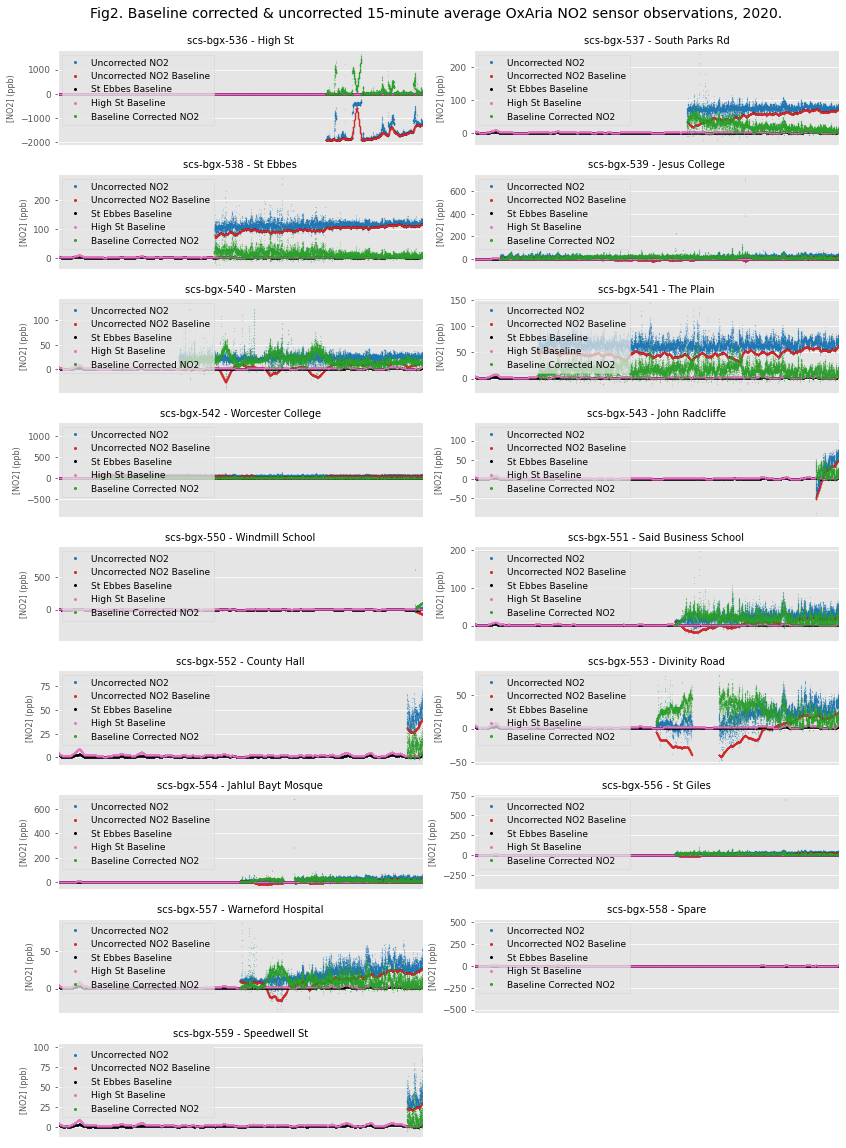

In [11]:
# Plot 15-minute sensor no2, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2020, 12, 31, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=True,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig2. Baseline corrected & uncorrected 15-minute average OxAria NO2 sensor observations, 2020.',
    fontsize=14,
    y=0.91)

for tag, dat in gases.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.no2.cnc_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected NO2', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected NO2 Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(y='no2_ppb_s_bl', c='k',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(y='no2_ppb_h_bl', c='tab:pink',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='High St Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_c0', c='tab:green',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Baseline Corrected NO2', ax=ax, legend=True, zorder=1)
    #dat.plot(x='rec',y='val.no2.cnc_c0_bl', c='lime',linewidth=0.5, marker='o', ms=0.2, ls='', \
    #         label='Correction0_bl', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    #ax.set_xticklabels()
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(myFmt)
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.75, loc='upper left', fontsize=9)
fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratifie.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [12]:
# Calc baseline of the corrected no2 sensor trace
#-------------------------------------------------
tmp_list = []

for tag, df in gases.reset_index().groupby('tag'):
    #if tag not in 'scs-bgx-536':
    tmp0 = df.dropna(subset=['rec', 'val.no2.cnc_1_c0'], axis=0)
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.no2.cnc_1_c0'].values
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  # these default values seem to deliver good results, stay with
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.no2.cnc_1_c0_bl'])
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)  # .set_index('rec',drop=True)
    tmp_list.append(tmp1)
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True)  
gases = pd.merge(gases, tmp_df, how='left', on=['tag','rec'])
gases = gases.reset_index(['tag']).merge(auto_merged[['no2_ppb_s_bl','no2_ppb_h_bl']], how='left', on='rec')
gases['no2_1_c0_bl_offset1'] = gases['no2_ppb_s_bl'] - gases['val.no2.cnc_1_c0_bl']
gases['val.no2.cnc_1_c1neg'] = gases['val.no2.cnc_1_c0'] + gases['no2_1_c0_bl_offset1']
gases['val.no2.cnc_1_c1'] = np.where(gases['val.no2.cnc_1_c1neg'].lt(0),np.nan,gases['val.no2.cnc_1_c1neg'])
gases = gases.reset_index().set_index(['tag','rec'])


In [13]:
gases['no2_1_c0_bl_offset1'].describe()

count    236041.000000
mean          2.402650
std           5.667827
min         -93.889253
25%           0.774943
50%           1.960922
75%           3.598851
max          37.521329
Name: no2_1_c0_bl_offset1, dtype: float64

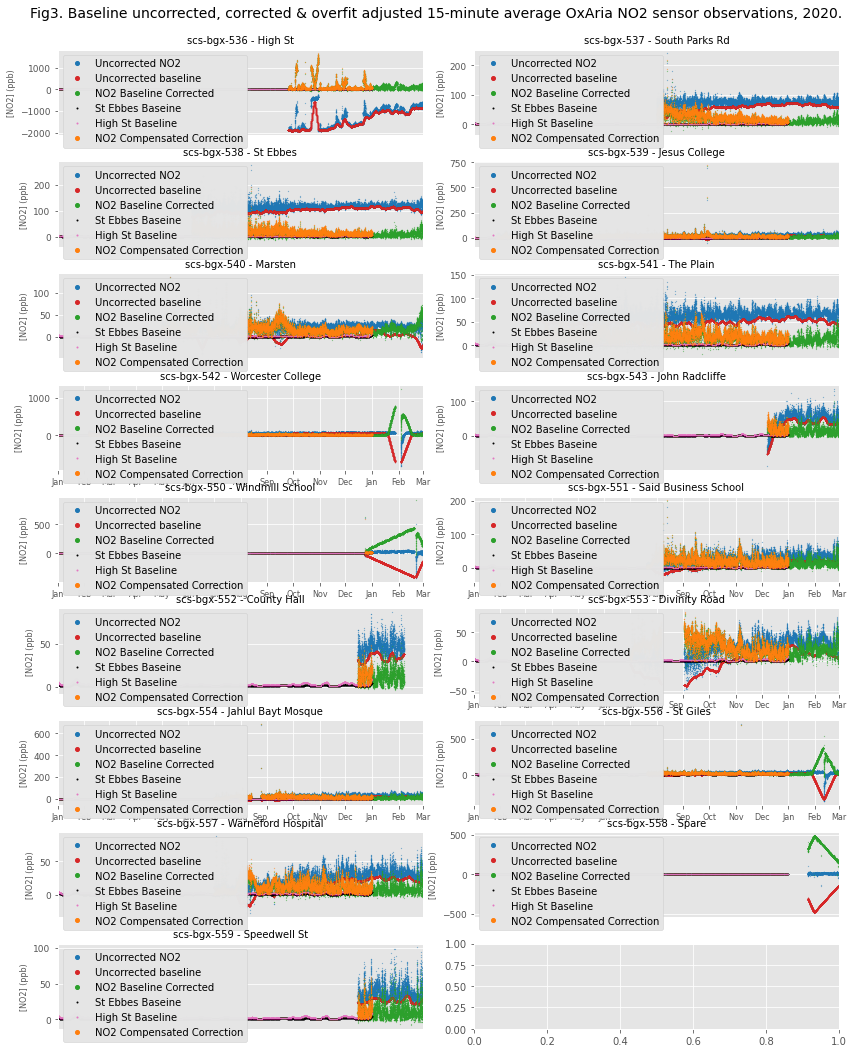

In [14]:
# Plot 15-minute sensor no2, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1, 0, 0, 0, 0)
end_date = dt.datetime(2021, 3, 1, 0, 0, 0, 0)
labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
    'Nov', 'Dec'
]
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
locations = list(pd.date_range(start_date, end_date, freq='M', normalize=True))

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig3. Baseline uncorrected, corrected & overfit adjusted 15-minute average OxAria NO2 sensor observations, 2020.',
    fontsize=14,
    y=0.91)
for tag, dat in gases.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat.plot(x='rec',y='val.no2.cnc_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected NO2', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='Uncorrected baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_c0', c='tab:green',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='NO2 Baseline Corrected', ax=ax, legend=True, zorder=1)
    auto_merged.plot(y='no2_ppb_s_bl', c='k',linewidth=0.5, marker='o', ms=0.05, ls='', \
             label='St Ebbes Baseine', ax=ax, legend=True, zorder=1)
    auto_merged.plot(y='no2_ppb_h_bl', c='tab:pink',linewidth=0.5, marker='o', ms=0.05, ls='', \
             label='High St Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.no2.cnc_1_c1', c='tab:orange',linewidth=0.5, marker='o', ms=0.2, ls='', \
             label='NO2 Compensated Correction', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    #ax.set_xticklabels(labels)
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(myFmt)
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.99, loc='upper left')
#fig.delaxes(axes_list.pop(-1))

plt.savefig(pngs+'oxaria0_no2_15m_raw_sensor_ts_ratified.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [15]:
# Get number of corrected values below zero, then remove them
#--------------------------------------------------------------
#df = gases.loc[:,['name','val.no2.cnc_1_c1']]

print("Total no. of baseline corrected observations =  " +
      str(gases['val.no2.cnc_1_c1neg'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(gases['val.no2.cnc_1_c1neg'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(gases['val.no2.cnc_1_c1neg'].lt(0).sum() /
          gases['val.no2.cnc_1_c1neg'].count() * 100))

#df['no_zeros'] = np.where(df['val.no2.cnc_1_c1'].lt(0),np.nan,df['val.no2.cnc_1_c1'])

print("\nAfter replacing zeros with np.nans...\nTotal no. of baseline corrected observations =  " +
      str(gases['val.no2.cnc_1_c1'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(gases['val.no2.cnc_1_c1'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(gases['val.no2.cnc_1_c1'].lt(0).sum() /
          gases['val.no2.cnc_1_c1'].count() * 100))

Total no. of baseline corrected observations =  236041
Total no. of bl corrected obs. below zero =  952
Total no. of bl corrected obs. below zero as % of total =  0.4033197622446948

After replacing zeros with np.nans...
Total no. of baseline corrected observations =  235089
Total no. of bl corrected obs. below zero =  0
Total no. of bl corrected obs. below zero as % of total =  0.0


In [17]:
# Write to feather file
#-----------------------
gases.reset_index().to_feather(the_folder+'oxaria_gases_536_stable15_bl_adjusted_ratified.ftr')


In [2]:
# Join the baseline analysis data on to the feature dataset
#-----------------------------------------------------------
# load the datasets
gases = pd.read_feather(the_folder+'oxaria_gases_536_stable15_bl_adjusted_ratified.ftr')
gases.info()

# Load AURN 15-min data as single df
#------------------------------------
auto_merged = pd.read_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/auto_merged_ratified.ftr')

# Quite possible the baselines will have already been calculated, 
# so dropping these for recalc
#auto_merged.drop(columns=['no2_ppb_h_bl', 'no2_ppb_s_bl'],
#                 axis=1,
#                 inplace=True)
# Quite possible the baselines will have already been calculated,
# so dropping these for recalc
try:
    auto_merged.drop(
        columns=['no2_ppb_h_bl', 'no2_ppb_s_bl'],
        axis=1,
        inplace=True)
except Exception:
    pass

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339525 entries, 0 to 339524
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   tag                  339525 non-null  object             
 1   rec                  339525 non-null  datetime64[ns, UTC]
 2   val.no2.wev          339525 non-null  float32            
 3   val.no2.cnc          339525 non-null  float32            
 4   val.no2.aev          339525 non-null  float32            
 5   val.no2.wec          339525 non-null  float32            
 6   val.sht.hmd          339525 non-null  float32            
 7   val.sht.tmp          339525 non-null  float32            
 8   val.no2.cnc_1        335248 non-null  float32            
 9   name                 339525 non-null  object             
 10  val.no2.cnc_1_bl     335248 non-null  float64            
 11  val.no2.cnc_1_c0     335248 non-null  float64            
 12  va

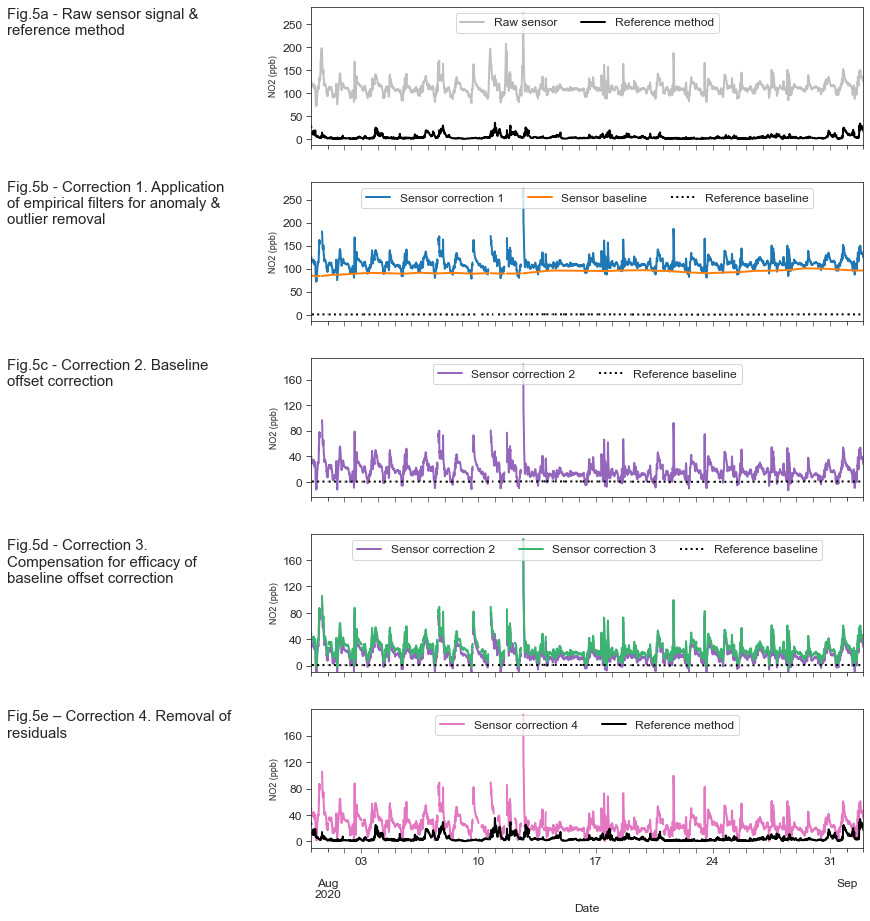

In [74]:
import seaborn as sns
import pytz

myFmt = mdates.DateFormatter('%d-%b')
sns.set_style("ticks")

aug = dt.datetime(2020, 7, 31, 0, 0, 0, tzinfo=pytz.utc)
sep = dt.datetime(2020, 9, 2, 0, 0, 0, tzinfo=pytz.utc)

df = gases.query('tag == "scs-bgx-538"').reset_index()
df = df.query('@aug < rec <= @sep')
df = df.dropna(subset=['rec'])
df1 = auto_merged.reset_index().query('@aug < rec <= @sep').dropna(subset=['rec'])

fig, (ax1,ax3,ax4,ax5,ax6) = plt.subplots(5, 1, figsize=(14,13), sharex=True, sharey=False)

plt.rcParams.update({'font.size': 12})
plt.rcParams["ytick.direction"] = 'out'
plt.rcParams["ytick.minor.visible"] = False
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 5

locator = mdates.AutoDateLocator(minticks=1, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax6.xaxis.set_major_locator(locator)
ax6.xaxis.set_major_formatter(formatter)


# ax1
df.plot(
    x='rec',
    y='val.no2.cnc',
    label='Raw sensor',
    color='silver',
    markeredgewidth=0.0,
    lw=2,
    ax=ax1
)
df1.plot(
    x='rec',
    y='no2_ppb_s',
    label='Reference method',
    color='k',
    ls='-',
    markeredgewidth=0.0,
    lw=2,
    ax=ax1
)
# ax3
df.plot(
    x='rec',
    y='val.no2.cnc_1',
    label='Sensor correction 1',
    color='tab:blue',
    lw=2,
    markeredgewidth=0.0,
    ax=ax3
)
df.plot(
    x='rec',
    y='val.no2.cnc_1_bl',
    label='Sensor baseline',
    color='tab:orange',
    markeredgewidth=0.0,
    lw=2,
    ax=ax3
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    ls=':',
    lw=2,
    ax=ax3
)
# ax4
df.plot(
    x='rec',
    y='val.no2.cnc_1_c0',
    label='Sensor correction 2',
    color='tab:purple',
    markeredgewidth=0.0,
    lw=2,
   ax=ax4
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    ls=':',
    lw=2,
    ax=ax4
)

# ax5
df.plot(
    x='rec',
    y='val.no2.cnc_1_c0',
    label='Sensor correction 2',
    color='tab:purple',
    markeredgewidth=0.0,
    lw=2,
   ax=ax5
)
df.plot(
    x='rec',
    y='val.no2.cnc_1_c1neg',
    label='Sensor correction 3',
    color='mediumseagreen',
    markeredgewidth=0.0,
    lw=2,
    ax=ax5
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    lw=2,
    ls=':',
    ax=ax5
)
# ax6
df.plot(
    x='rec',
    y='val.no2.cnc_1_c1',
    label='Sensor correction 4',
    color='tab:pink',
    lw=2,
    #marker='.',
    #mec='k',
    ax=ax6
)
df1.plot(
    x='rec',
    y='no2_ppb_s',
    label='Reference method',
    color='k',
    markeredgewidth=0.0,
    lw=2,
    ax=ax6
)

ax1.annotate('Fig.5a - Raw sensor signal & \nreference method',
             xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)
#ax1.set_title('Fig.5a - Raw sensor signal & \nreference method', y=0.2, pad=-25,fontsize=14, ha='left')
ax3.annotate('Fig.5b - Correction 1. Application \nof empirical filters for anomaly & \noutlier removal',
             xy=(-0.55, 0.7), xycoords='axes fraction', fontsize=15)
ax4.annotate('Fig.5c - Correction 2. Baseline \noffset correction',
             xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)
ax5.annotate('Fig.5d - Correction 3. \nCompensation for efficacy of\nbaseline offset correction',
             xy=(-0.55, 0.65), xycoords='axes fraction', fontsize=15)
ax6.annotate(' \nFig.5e – Correction 4. Removal of \nresiduals',
             xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)

plt.ylim(-20,300)
ax5.set_ylim(-10,200)
ax6.set_ylim(-10,200)
ax1.set_yticks(np.arange(0,300,50))
ax3.set_yticks(np.arange(0,300,50))
ax4.set_yticks(np.arange(0,200,40))
ax5.set_yticks(np.arange(0,200,40))
ax6.set_yticks(np.arange(0,200,40))
ax1.legend(ncol=3,loc='upper center')
ax3.legend(ncol=3,loc='upper center')
ax4.legend(ncol=3,loc='upper center')
ax5.legend(ncol=3,loc='upper center')
ax6.legend(ncol=3,loc='upper center')

ax1.set_ylabel('NO2 (ppb)', fontsize=9)
ax3.set_ylabel('NO2 (ppb)', fontsize=9)
ax4.set_ylabel('NO2 (ppb)', fontsize=9)
ax5.set_ylabel('NO2 (ppb)', fontsize=9)
ax6.set_ylabel('NO2 (ppb)', fontsize=9)

ax6.set_xlabel('Date')
#plt.subplots_adjust(right=0.1, hspace=0.3)
plt.tight_layout()


plt.savefig(pngs+'sebbes_no2_15m_raw_sensor_baseline_adjust_ratified.png',bbox_inches = "tight")


plt.show() 

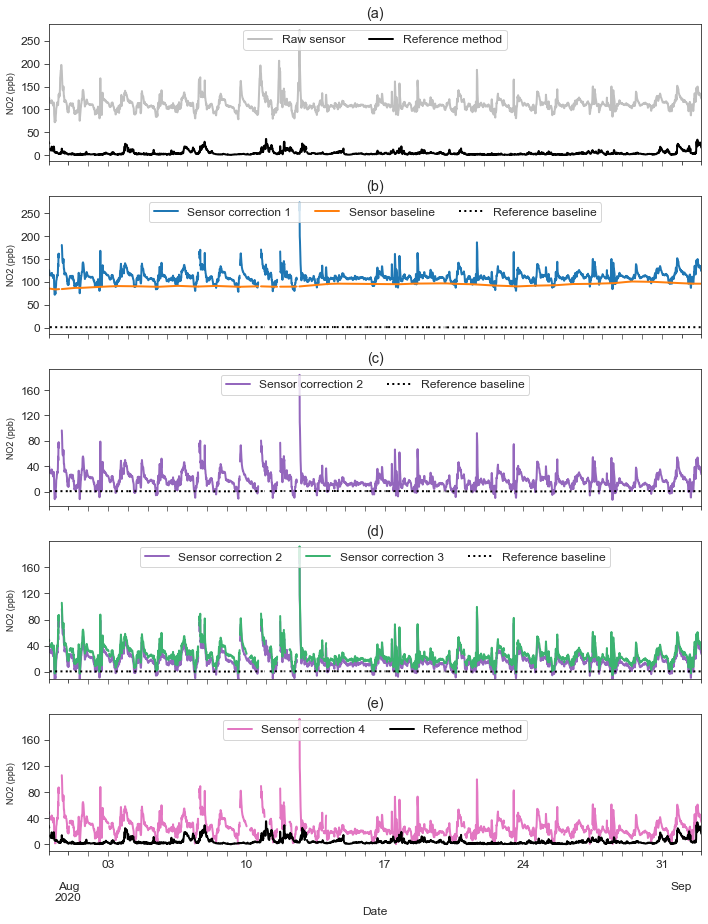

In [8]:
import seaborn as sns
import pytz

myFmt = mdates.DateFormatter('%d-%b')
sns.set_style("ticks")

aug = dt.datetime(2020, 7, 31, 0, 0, 0, tzinfo=pytz.utc)
sep = dt.datetime(2020, 9, 2, 0, 0, 0, tzinfo=pytz.utc)

df = gases.query('tag == "scs-bgx-538"').reset_index()
df = df.query('@aug < rec <= @sep')
df = df.dropna(subset=['rec'])
df1 = auto_merged.reset_index().query('@aug < rec <= @sep').dropna(subset=['rec'])

fig, (ax1,ax3,ax4,ax5,ax6) = plt.subplots(5, 1, figsize=(10,13), sharex=True, sharey=False)

plt.rcParams.update({'font.size': 12})
plt.rcParams["ytick.direction"] = 'out'
plt.rcParams["ytick.minor.visible"] = False
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 5

locator = mdates.AutoDateLocator(minticks=1, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax6.xaxis.set_major_locator(locator)
ax6.xaxis.set_major_formatter(formatter)


# ax1
df.plot(
    x='rec',
    y='val.no2.cnc',
    label='Raw sensor',
    color='silver',
    markeredgewidth=0.0,
    lw=2,
    ax=ax1,
    title='(a)'
)
df1.plot(
    x='rec',
    y='no2_ppb_s',
    label='Reference method',
    color='k',
    ls='-',
    markeredgewidth=0.0,
    lw=2,
    ax=ax1,
)
# ax3
df.plot(
    x='rec',
    y='val.no2.cnc_1',
    label='Sensor correction 1',
    color='tab:blue',
    lw=2,
    markeredgewidth=0.0,
    ax=ax3,
    title='(b)'
)
df.plot(
    x='rec',
    y='val.no2.cnc_1_bl',
    label='Sensor baseline',
    color='tab:orange',
    markeredgewidth=0.0,
    lw=2,
    ax=ax3,
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    ls=':',
    lw=2,
    ax=ax3,
)
# ax4
df.plot(
    x='rec',
    y='val.no2.cnc_1_c0',
    label='Sensor correction 2',
    color='tab:purple',
    markeredgewidth=0.0,
    lw=2,
    ax=ax4,
    title='(c)'
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    ls=':',
    lw=2,
    ax=ax4
)

# ax5
df.plot(
    x='rec',
    y='val.no2.cnc_1_c0',
    label='Sensor correction 2',
    color='tab:purple',
    markeredgewidth=0.0,
    lw=2,
    ax=ax5,
    title='(d)'
)
df.plot(
    x='rec',
    y='val.no2.cnc_1_c1neg',
    label='Sensor correction 3',
    color='mediumseagreen',
    markeredgewidth=0.0,
    lw=2,
    ax=ax5
)
df.plot(
    x='rec',
    y='no2_ppb_s_bl',
    label='Reference baseline',
    color='k',
    markeredgewidth=0.0,
    lw=2,
    ls=':',
    ax=ax5,
    title=''
)
# ax6
df.plot(
    x='rec',
    y='val.no2.cnc_1_c1',
    label='Sensor correction 4',
    color='tab:pink',
    lw=2,
    ax=ax6,
    title='(e)'
)
df1.plot(
    x='rec',
    y='no2_ppb_s',
    label='Reference method',
    color='k',
    markeredgewidth=0.0,
    lw=2,
    ax=ax6
)

# ax1.annotate('Fig.5a - Raw sensor signal & \nreference method',
#              xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)
# #ax1.set_title('Fig.5a - Raw sensor signal & \nreference method', y=0.2, pad=-25,fontsize=14, ha='left')
# ax3.annotate('Fig.5b - Correction 1. Application \nof empirical filters for anomaly & \noutlier removal',
#              xy=(-0.55, 0.7), xycoords='axes fraction', fontsize=15)
# ax4.annotate('Fig.5c - Correction 2. Baseline \noffset correction',
#              xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)
# ax5.annotate('Fig.5d - Correction 3. \nCompensation for efficacy of\nbaseline offset correction',
#              xy=(-0.55, 0.65), xycoords='axes fraction', fontsize=15)
# ax6.annotate(' \nFig.5e – Correction 4. Removal of \nresiduals',
#              xy=(-0.55, 0.8), xycoords='axes fraction', fontsize=15)

plt.ylim(-20,300)
ax5.set_ylim(-10,200)
ax6.set_ylim(-10,200)
ax1.set_yticks(np.arange(0,300,50))
ax3.set_yticks(np.arange(0,300,50))
ax4.set_yticks(np.arange(0,200,40))
ax5.set_yticks(np.arange(0,200,40))
ax6.set_yticks(np.arange(0,200,40))
ax1.legend(ncol=3,loc='upper center')
ax3.legend(ncol=3,loc='upper center')
ax4.legend(ncol=3,loc='upper center')
ax5.legend(ncol=3,loc='upper center')
ax6.legend(ncol=3,loc='upper center')

ax1.set_ylabel('NO2 (ppb)', fontsize=9)
ax3.set_ylabel('NO2 (ppb)', fontsize=9)
ax4.set_ylabel('NO2 (ppb)', fontsize=9)
ax5.set_ylabel('NO2 (ppb)', fontsize=9)
ax6.set_ylabel('NO2 (ppb)', fontsize=9)

ax6.set_xlabel('Date')
#plt.subplots_adjust(right=0.1, hspace=0.3)
plt.tight_layout()


plt.savefig(pngs+'sebbes_no2_15m_raw_sensor_baseline_adjust_ratified.png',bbox_inches = "tight")


plt.show() 

In [19]:
# Select St Ebbes only & baseline / correction columns generated above
#----------------------------------------------------------------------
sebbes_sensor_bl_info = gases.query('tag == "scs-bgx-538"').loc[:, [
    'tag', 'rec', 'val.no2.cnc_1_bl', 'val.no2.cnc_1_c0', 'val.no2.cnc_1_c1',
    'val.no2.cnc_1_c0_bl', 'no2_ppb_s_bl', 'no2_ppb_h_bl'
]]
sebbes_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25824 entries, 35424 to 61247
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tag                  25824 non-null  object             
 1   rec                  25824 non-null  datetime64[ns, UTC]
 2   val.no2.cnc_1_bl     25613 non-null  float64            
 3   val.no2.cnc_1_c0     25613 non-null  float64            
 4   val.no2.cnc_1_c1     19193 non-null  float64            
 5   val.no2.cnc_1_c0_bl  25613 non-null  float64            
 6   no2_ppb_s_bl         19471 non-null  float32            
 7   no2_ppb_h_bl         19471 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(2), float64(4), object(1)
memory usage: 1.6+ MB


In [20]:
# Select St Ebbes only & baseline / correction columns generated above
#----------------------------------------------------------------------
highs_sensor_bl_info = gases.query('tag == "scs-bgx-536"').loc[:, [
    'tag', 'rec', 'val.no2.cnc_1_bl', 'val.no2.cnc_1_c0', 'val.no2.cnc_1_c1',
    'val.no2.cnc_1_c0_bl', 'no2_ppb_s_bl', 'no2_ppb_h_bl'
]]
highs_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15072 entries, 0 to 15071
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tag                  15072 non-null  object             
 1   rec                  15072 non-null  datetime64[ns, UTC]
 2   val.no2.cnc_1_bl     15072 non-null  float64            
 3   val.no2.cnc_1_c0     15072 non-null  float64            
 4   val.no2.cnc_1_c1     9055 non-null   float64            
 5   val.no2.cnc_1_c0_bl  15072 non-null  float64            
 6   no2_ppb_s_bl         9143 non-null   float32            
 7   no2_ppb_h_bl         9143 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(2), float64(4), object(1)
memory usage: 942.0+ KB


In [21]:
# Load the training info we identified in step (7)
#-------------------------------------------------
sebbes_train_s15 = pd.read_feather(the_folder + 'sebbes_train_536_s15_ratified.ftr')
sebbes_train_s15.info(max_cols=200)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                20160 non-null  object             
 1   rec                20160 non-null  datetime64[ns, UTC]
 2   val.no2.wev        20160 non-null  float32            
 3   val.no2.cnc        20160 non-null  float32            
 4   val.no2.aev        20160 non-null  float32            
 5   val.no2.wec        20160 non-null  float32            
 6   val.sht.hmd_g      20160 non-null  float32            
 7   val.sht.tmp_g      20160 non-null  float32            
 8   val.no2.cnc_1      19949 non-null  float32            
 9   name               20160 non-null  object             
 10  val.hmd            20160 non-null  float32            
 11  val.tmp            20160 non-null  float32            
 12  val.mtf1           20160 non-null  float32    

In [22]:
# Load the training info we identified in step (7)
#-------------------------------------------------
highs_train_s15 = pd.read_feather(the_folder + 'highs_train_536_s15_ratified.ftr')
highs_train_s15.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tag                9408 non-null   object             
 1   rec                9408 non-null   datetime64[ns, UTC]
 2   val.no2.wev        9408 non-null   float32            
 3   val.no2.cnc        9408 non-null   float32            
 4   val.no2.aev        9408 non-null   float32            
 5   val.no2.wec        9408 non-null   float32            
 6   val.sht.hmd_g      9408 non-null   float32            
 7   val.sht.tmp_g      9408 non-null   float32            
 8   val.no2.cnc_1      9408 non-null   float32            
 9   name               9408 non-null   object             
 10  val.hmd            9408 non-null   float32            
 11  val.tmp            9408 non-null   float32            
 12  val.mtf1           9408 non-null   float32      

In [23]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = sebbes_train_s15.merge(sebbes_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info(max_cols=200)

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(the_folder+'sebbes_train_536_s15_ratified.ftr')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20160 entries, 0 to 20159
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tag                  20160 non-null  object             
 1   rec                  20160 non-null  datetime64[ns, UTC]
 2   val.no2.wev          20160 non-null  float32            
 3   val.no2.cnc          20160 non-null  float32            
 4   val.no2.aev          20160 non-null  float32            
 5   val.no2.wec          20160 non-null  float32            
 6   val.sht.hmd_g        20160 non-null  float32            
 7   val.sht.tmp_g        20160 non-null  float32            
 8   val.no2.cnc_1        19949 non-null  float32            
 9   name                 20160 non-null  object             
 10  val.hmd              20160 non-null  float32            
 11  val.tmp              20160 non-null  float32            
 12  val.mtf1          

In [24]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = highs_train_s15.merge(highs_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info(max_cols=200)

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(the_folder+'highs_train_536_s15_ratified.ftr')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9408 entries, 0 to 9407
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tag                  9408 non-null   object             
 1   rec                  9408 non-null   datetime64[ns, UTC]
 2   val.no2.wev          9408 non-null   float32            
 3   val.no2.cnc          9408 non-null   float32            
 4   val.no2.aev          9408 non-null   float32            
 5   val.no2.wec          9408 non-null   float32            
 6   val.sht.hmd_g        9408 non-null   float32            
 7   val.sht.tmp_g        9408 non-null   float32            
 8   val.no2.cnc_1        9408 non-null   float32            
 9   name                 9408 non-null   object             
 10  val.hmd              9408 non-null   float32            
 11  val.tmp              9408 non-null   float32            
 12  val.mtf1            